# ===============================================================
# -
#  -   -   Read in and process California reservoir elevation, temperature and upstream/downstream temperature
# -
# ===============================================================

In [1]:
import pandas as pd
import re
from ulmo import cdec
from ulmo import util
import matplotlib.pyplot as plt

DEFAULT_START_DATE = '01/01/1901'
DEFAULT_END_DATE = 'Now'


In [2]:
# Map of California reservoirs: https://upload.wikimedia.org/wikipedia/commons/7/7c/Water_in_California_new.png

In [4]:
def _limit_sensor_list(sensor_list, sensor_ids, resolution):

    if sensor_ids is not None:
        sensor_list = sensor_list[[x in sensor_ids for x in sensor_list.sensor_id]]

    if resolution is not None:
        sensor_list = sensor_list[[x in resolution for x in sensor_list.resolution]]

    return sensor_list


def _download_raw(station_id, sensor_num, dur_code, start_date, end_date):

    url = 'http://cdec.water.ca.gov/cgi-progs/queryCSV' + \
        '?station_id=' + station_id + \
        '&dur_code=' + dur_code + \
        '&sensor_num=' + str(sensor_num) + \
        '&start_date=' + start_date + \
        '&end_date=' + end_date

    df = pd.read_csv(url, skiprows=2, header=None, parse_dates=[[0,1]], index_col=None, na_values='m')
    df.columns = ['datetime', 'value']
    df.set_index('datetime', inplace=True)

    return df


def _res_to_dur_code(res):
    map = {
        'hourly':'H',
        'daily':'D',
        'monthly':'M',
        'event':'E'}

    return map[res]


def _format_date(date):
    return '%s/%s/%s' % (date.month, date.day, date.year)

In [14]:
def get_stations():
    """Fetches information on all CDEC sites.
    Returns
    -------
    df : pandas DataFrame
        a pandas DataFrame (indexed on site id) with station information.
    """
        # I haven't found a better list of stations, seems pretty janky
        # to just have them in a file, and not sure if/when it is updated.
    url = 'http://cdec.water.ca.gov/misc/all_stations.csv'
        # the csv is malformed, so some rows think there are 7 fields
    col_names = ['id','meta_url','name','num','lat','lon','junk']
    df = pd.read_csv(url, names=col_names, header=None, quotechar="'",index_col=0)

    return df


In [15]:
stations = get_stations()

In [7]:
#stations.to_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations_initial.csv', index=None)

In [16]:
stations.tail()

,meta_url,name,num,lat,lon,junk
id,,,,,,
YUB,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,FEATHER RIVER AT YUBA CITY,80,39.133,121.6,NaN
YUC,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,YUCCA VALLEY,3100,34.123,116.408,NaN
YYV,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,YOSEMITE AT YOSEMITE VALLEY,4200,37.74,119.589,NaN
ZEN,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ZENIA,4000,40.208,123.46,NaN
ZPC,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ZAPATO CHINO,1150,36.016,120.293,NaN


In [63]:
print(stations.index[200:300])

Index(['BNG', 'BNH', 'BNK', 'BNL', 'BNM', 'BNP', 'BNR', 'BNS', 'BNV', 'BNY',
       'BOB', 'BOC', 'BOM', 'BOW', 'BP1', 'BP2', 'BP3', 'BPD', 'BPF', 'BPG',
       'BPI', 'BPK', 'BPM', 'BPN', 'BPP', 'BPT', 'BQC', 'BRA', 'BRB', 'BRC',
       'BRD', 'BRE', 'BRG', 'BRH', 'BRI', 'BRK', 'BRL', 'BRM', 'BRN', 'BRO',
       'BRP', 'BRR', 'BRS', 'BRT', 'BRV', 'BRW', 'BRY', 'BSC', 'BSF', 'BSH',
       'BSK', 'BSL', 'BSM', 'BSO', 'BSP', 'BSR', 'BSS', 'BTA', 'BTC', 'BTD',
       'BTH', 'BTJ', 'BTM', 'BTN', 'BTR', 'BTS', 'BTT', 'BTV', 'BUC', 'BUK',
       'BUL', 'BUN', 'BUP', 'BUR', 'BUT', 'BV1', 'BV2', 'BVE', 'BVL', 'BVY',
       'BWC', 'BWH', 'BWN', 'BWR', 'BWS', 'BWV', 'BWY', 'BXC', 'BXP', 'BYC',
       'BYM', 'BZR', 'C12', 'C13', 'C18', 'C21', 'C29', 'C41', 'C66', 'CAD'],
      dtype='object', name='id')


In [10]:
def get_station_sensors(station_ids=None, sensor_ids=None, resolutions=None):
    """
    Gets available sensors for the given stations, sensor ids and time
    resolutions. If no station ids are provided, all available stations will
    be used (this is not recommended, and will probably take a really long
    time).
    The list can be limited by a list of sensor numbers, or time resolutions
    if you already know what you want. If none of the provided sensors or
    resolutions are available, an empty DataFrame will be returned for that
    station.
    Usage example::
        from ulmo import cdec
        # to get all available sensors
        available_sensors = cdec.historical.get_station_sensors(['NEW'])
    Parameters
    ----------
    station_ids : iterable of strings or ``None``
    sensor_ids : iterable of integers or ``None``
        check out  or use the ``get_sensors()`` function to see a list of
        available sensor numbers
    resolutions : iterable of strings or ``None``
        Possible values are 'event', 'hourly', 'daily', and 'monthly' but not
        all of these time resolutions are available at every station.
    Returns
    -------
    dict : a python dict
        a python dict with site codes as keys with values containing pandas
        DataFrames of available sensor numbers and metadata.
    """

    station_sensors = {}
        
    if station_ids is None:
        station_ids = get_stations().index


    for station_id in station_ids:
        url = 'http://cdec.water.ca.gov/cgi-progs/queryCSV?station_id=%s' % (station_id)
        
        sensor_list = pd.read_html(url)[0]
        
        sensor_list.columns = ['sensor_id','variable','resolution','timerange']
        v = sensor_list.variable.to_dict().values()

        split = [re.split(r'[\(\)]+',x) for x in v]
        var_names = [x[0] for x in split]
        units = [x[1] for x in split]
        var_resolution = [re.split(r'[\(\)]+',x)[1] for x in sensor_list.resolution]

        sensor_list['resolution'] = var_resolution
        sensor_list['variable'] = [x + y for x, y in zip(var_names, var_resolution)]
        sensor_list['units'] = pd.Series(units,index=sensor_list.index)

        station_sensors[station_id] = _limit_sensor_list(sensor_list, sensor_ids, resolutions)

    return station_sensors

In [11]:
data = get_station_sensors(station_ids=['SHA'])

In [13]:
data

{'SHA':     sensor_id                               variable resolution  \
 0           2       PRECIPITATION, ACCUMULATED daily      daily   
 1           2     PRECIPITATION, ACCUMULATED monthly    monthly   
 2           6              RESERVOIR ELEVATION daily      daily   
 3           6             RESERVOIR ELEVATION hourly     hourly   
 4           8                FULL NATURAL FLOW daily      daily   
 5          15                RESERVOIR STORAGE daily      daily   
 6          15               RESERVOIR STORAGE hourly     hourly   
 7          15              RESERVOIR STORAGE monthly    monthly   
 8          22        RESERVOIR, STORAGE CHANGE daily      daily   
 9          23                RESERVOIR OUTFLOW daily      daily   
 10         23               RESERVOIR OUTFLOW hourly     hourly   
 11         45       PRECIPITATION, INCREMENTAL daily      daily   
 12         48      DISCHARGE, POWER GENERATION daily      daily   
 13         68  EVAPORATION, LAKE COMPUTE

In [8]:
def get_data(station_ids=None, sensor_ids=None, resolutions=None, start=None, end=None):
    """
    Downloads data for a set of CDEC station and sensor ids. If either is not
    provided, all available data will be downloaded. Be really careful with
    choosing hourly resolution as the data sets are big, and CDEC's servers
    are slow as molasses in winter.
    Usage example::
        from ulmo import cdec
        dat = cdec.historical.get_data(['PRA'],resolutions=['daily'])
    Parameters
    ----------
    station_ids : iterable of strings or ``None``
    sensor_ids : iterable of integers or ``None``
        check out  or use the ``get_sensors()`` function to see a list of
        available sensor numbers
    resolutions : iterable of strings or ``None``
        Possible values are 'event', 'hourly', 'daily', and 'monthly' but not
        all of these time resolutions are available at every station.
    Returns
    -------
    dict : a python dict
        a python dict with site codes as keys. Values will be nested dicts
        containing all of the sensor/resolution combinations.
    """

    if start is None:
        start_date = util.convert_date(DEFAULT_START_DATE)
    else:
        start_date = util.convert_date(start)
    if end is None:
        end_date = util.convert_date(DEFAULT_END_DATE)
    else:
        end_date = util.convert_date(end)

    start_date_str = _format_date(start_date)
    end_date_str = _format_date(end_date)

    if station_ids is None:
        station_ids = get_stations().index

    sensors = get_station_sensors(station_ids, sensor_ids, resolutions)
    print(sensors)
    
    d = {}

    for station_id, sensor_list in sensors.items():
        station_data = {}

        for index, row in sensor_list.iterrows():
            res = row.ix['resolution']
            var = row.ix['variable']
            sensor_id = row.ix['sensor_id']
            station_data[var] = _download_raw(station_id, sensor_id, _res_to_dur_code(res), start_date_str, end_date_str)

        d[station_id] = station_data

    return d

In [9]:
i = 'SJL'
#dat = cdec.historical.get_data([i],sensor_ids=[11],resolutions=['daily'])
dat = cdec.historical.get_data([i], sensor_ids=[25])

CParserError: Error tokenizing data. C error: Expected 1 fields in line 13, saw 2


In [ ]:
print(dat)

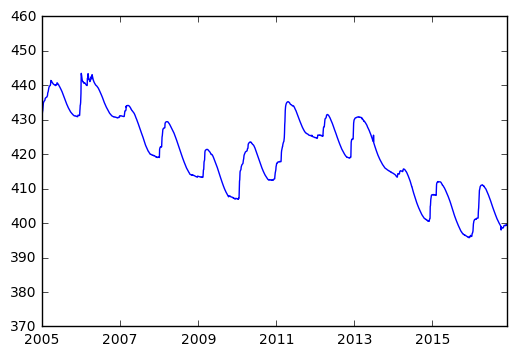

In [22]:
plt.plot(dat[i]['RESERVOIR ELEVATION daily'])
axes = plt.gca()
axes.set_xlim(['01-01-2005','12-01-2016'])
axes.set_ylim([370,460])
plt.show()

# =====================================================================
#
##   Read all sites and list which have reservoir elevation data
#
# =====================================================================

In [112]:
print(len(res_stations))
print(len(res_stationsx))

83
81


In [9]:
res_stationsx = res_stations
res_stationsx = res_stationsx[0:5] 
res_stationsx = res_stationsx.append(res_stations[7:len(res_stations)])

NameError: name 'res_stations' is not defined

stationx

In [ ]:
res_stations = pd.DataFrame()

In [97]:
# =================================================================
#
# =================================================================

# SET BOTH OF THESE TO "0" at first!!!!!!
last_tot_count = 1799    # larger number
last_count = 75         # smaller number

stationsx = stations.index
stationsx = stationsx[last_tot_count:len(stationsx)]  # put start value same as last printed (it is the next one)

countx = last_count
totcountx = last_tot_count
for stationx in stationsx:
    totcountx = totcountx + 1
    res_datax = cdec.historical.get_data(station_ids=[stationx],sensor_ids=[6],  resolutions=['daily'])
    if len(res_datax[stationx]) > 0:
        countx = countx + 1
        print(totcountx,countx,stationx)
        stationx2 = pd.DataFrame([stationx])
        res_stations = res_stations.append(stationx2)


1813 76 SWB
1826 77 TAB
1907 78 TRM
1915 79 TUL
1929 80 UNV
1990 81 WHI
2018 82 WRS
2026 83 WSN


In [132]:
# -------- to write CSVs ----------
# res_stationsx.to_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations.csv', index=None)
# res_stations.to_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations.csv', index=None)

In [6]:
# -------- to write CSVs ----------
res_stations = pd.read_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations.csv')
res_stations.columns = ['site_no']

In [18]:
res_stations.tail()

,site_no
76,TUL
77,UNV
78,WHI
79,WRS
80,WSN


In [21]:
#res_stationsx2 = res_stations[0]
#res_stationsx2 = res_stationsx2.iloc[16]
res_stationsx2 = 'MIL'

res_datax = cdec.historical.get_data(station_ids=[res_stationsx2],  resolutions=['daily'])
#                    start='2000-01-01',end='2013-01-01' )


In [23]:
res_datax[res_stationsx2]

{'DISCHARGE, SPILLWAY daily':             value
 datetime         
 2000-04-01    0.0
 2000-04-02    0.0
 2000-04-03    0.0
 2000-04-04    0.0
 2000-04-05    0.0
 2000-04-06    0.0
 2000-04-07    0.0
 2000-04-08    0.0
 2000-04-09    0.0
 2000-04-10    0.0
 2000-04-11    0.0
 2000-04-12    0.0
 2000-04-13    0.0
 2000-04-14    0.0
 2000-04-15    0.0
 2000-04-16    0.0
 2000-04-17    0.0
 2000-04-18    0.0
 2000-04-19    0.0
 2000-04-20    0.0
 2000-04-21    0.0
 2000-04-22    0.0
 2000-04-23    0.0
 2000-04-24    0.0
 2000-04-25    0.0
 2000-04-26    0.0
 2000-04-27    0.0
 2000-04-28    0.0
 2000-04-29    0.0
 2000-04-30    0.0
 ...           ...
 2017-01-12    0.0
 2017-01-13    0.0
 2017-01-14    0.0
 2017-01-15    0.0
 2017-01-16    0.0
 2017-01-17    0.0
 2017-01-18    0.0
 2017-01-19    0.0
 2017-01-20    0.0
 2017-01-21    0.0
 2017-01-22    0.0
 2017-01-23    0.0
 2017-01-24    0.0
 2017-01-25    0.0
 2017-01-26    0.0
 2017-01-27    0.0
 2017-01-28    0.0
 2017-01-29    0.0
 2

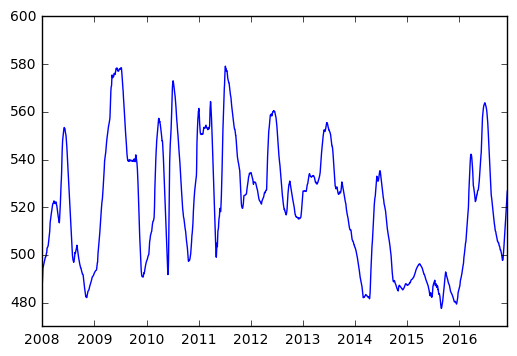

In [22]:
plt.plot(res_datax[res_stationsx2]['RESERVOIR ELEVATION daily'])
axes = plt.gca()
axes.set_xlim(['01-01-2008','12-01-2016'])
axes.set_ylim([470,600])
plt.show()

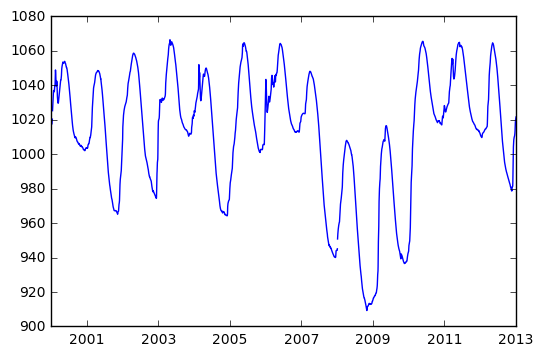

# =================================================
#
##   For each site with elevation data, read in temperature data
#
# ==================================================

# =================================================
#
##   Map Sites
#
# ==================================================

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import cartopy.io.shapereader as shpreader
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import calendar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np

In [13]:
np.array(stations.lon)

array(['116.037 ', '121.213 ', '36.467', ..., '119.589 ', '123.46 ',
       '120.293 '], dtype=object)

In [14]:
latx = np.array(stations.lat)
lonx = np.array(stations.lon)

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -105, 20, 49])  # SERC area
ax.coastlines()
plt.scatter(lonx, latx)
plt.show()

In [ ]:
# =============================================================================================================
#
#             SERC area
#
# =============================================================================================================

fig = plt.figure(figsize=(15,8))

def main():
    #ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-90, -80, 34, 38]) # TVA area
    ax.set_extent([-125, -105, 20, 49])  # SERC area

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='lightgray', zorder = 0)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 1)


    plt.scatter(stations.lon, stations.lat)
    
    plt.show()


if __name__ == '__main__':
    main()



In [ ]:
res_stations.columns = ['site_no']